# Table of contents

- [Introduction](#introduction)
- [Code](#code-section)
  - [Import necessary modules](#import-necessary-modules)
  - [Generate a simulated membrane](#generate-a-simulated-membrane)
  - [Add gaussian noise](#add-gaussian-noise)
  - [Minimize L1-norm to subtract membrane](#minimize-l1-norm-to-subtract-membrane)
- [Test](#test-section)
  - [Subtraction of line-like membrane](#subtraction-of-line-like-membrane)
  - [Subtraction of arc-like membrane](#subtraction-of-arc-like-membrane)

# Introduction

本文主要用于测试使用L1-norm minimization方法去膜的效果。

This document is mainly used to test the effect of membrane subtraction using the L1-norm minimization method in MemXTerminator.

# Code Section

## Import necessary modules


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.style.use('default')
from mpl_toolkits.mplot3d import Axes3D

## Generate a simulated membrane

这里使用和软件中一样的方法生成双高斯峰，模拟对raw image平均后信噪比较高的膜。

Here we use the same method as in the software to generate a double Gaussian peak to simulate a membrane with a high signal-to-noise ratio after averaging the raw image.

In [2]:
def gaussian_pdf(x, mean, std):
    coefficient = 1.0 / (std * np.sqrt(2 * np.pi))
    exponential = np.exp(- (x - mean) ** 2 / (2 * std ** 2))
    return coefficient * exponential

def gaussian2(x, membrane_dist, std1, std2):
    mean1 = - membrane_dist / 2
    mean2 = membrane_dist / 2
    gaussian1 = norm.pdf(x, mean1, std1)
    gaussian2 = norm.pdf(x, mean2, std2)
    g = gaussian1 + gaussian2
    g = g / np.sum(g)
    g = g * 255
    return g

In [3]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)
class Curve:
    def __init__(self, image_size, y0, x0, theta, sigma1, sigma2, membrane_distance, kappa):
        self.y0 = y0
        self.x0 = x0
        self.theta = theta
        self.image_size = image_size
        self.sigma1, self.sigma2 = sigma1, sigma2
        self.kappa = kappa
        self.x_c = 0
        self.y_c = 0
        self.R = 0
        self.membrane_distance = membrane_distance
        self.distance_matrix = np.zeros((self.image_size, self.image_size))
        self.simulate_membrane = np.zeros((self.image_size, self.image_size))
    def compute(self):
        if self.kappa == 0:
            return self.compute_line_dist()
        else:
            return self.compute_arc_dist()
    def compute_arc_center(self):
        self.R = 1 / np.abs(self.kappa) if self.kappa != 0 else np.inf
        if self.kappa >= 0:
            self.x_c = self.x0 - self.R * np.sin(self.theta)
            self.y_c = self.y0 + self.R * np.cos(self.theta)
        else:
            self.x_c = self.x0 + self.R * np.sin(self.theta)
            self.y_c = self.y0 - self.R * np.cos(self.theta)
        return self.x_c, self.y_c
    def if_in_arc(self, x_temp, y_temp):
        x_c, y_c = self.compute_arc_center()
        d = distance(x_c, y_c, x_temp, y_temp)
        if d <= self.R:
            return True
        else:
            return False
    def compute_arc_dist(self):
        x_c, y_c = self.compute_arc_center()
        x = range(self.image_size)
        y = range(self.image_size)
        for i in x:
            for j in y:
                distance_temp = distance(x_c, y_c, i, j) - self.R
                self.distance_matrix[i, j] = distance_temp
        return self.distance_matrix
    def compute_line_dist(self):
        x = range(self.image_size)
        y = range(self.image_size)
        if np.isclose(self.theta, np.pi/2) or np.isclose(self.theta, 3*np.pi/2):
            for i in x:
                for j in y:
                    self.distance_matrix[i, j] = i - self.x0
            return self.distance_matrix
        else:
            k = np.tan(self.theta)
            b = self.y0 - k * self.x0
            for i in x:
                for j in y:
                    self.distance_matrix[i, j] = (k * i - j + b) / np.sqrt(k**2 + 1)
            return self.distance_matrix
    def generate_membrane(self):
        self.distance_matrix = self.compute()
        self.simulate_membrane = gaussian2(self.distance_matrix, self.membrane_distance, self.sigma1, self.sigma2)
        return self.simulate_membrane
    
def generate_simulated_membrane(image_size, y0, x0, theta, sigma1, sigma2, membrane_distance, kappa):
    curve = Curve(image_size, y0, x0, theta, sigma1, sigma2, membrane_distance, kappa)
    membrane = curve.generate_membrane()
    return membrane

## Add gaussian noise

为了模拟raw image的情况，这里给膜图像添加了高斯噪声。

In order to simulate the situation of raw image, Gaussian noise is added to the membrane image here.

`SNR`定义为单纯膜信号图像的方差与单纯噪声图像的方差的比值。您可以调整`SNR`的值来改变噪声的强度。

`SNR` is defined as the ratio of the variance of the pure membrane signal image to the variance of the pure noise image. You can adjust the value of `SNR` to change the intensity of the noise.


In [4]:
def add_gaussian_noise(img, SNR):
    mean = 0
    variance = np.var(img)
    noise_img_variance = variance / SNR
    std = np.sqrt(noise_img_variance)
    print('add noise standard deviation: ', std)
    noise = np.random.normal(mean, std, (size, size))
    img_noise = img + noise
    return img_noise

## Minimize L1-norm to subtract membrane

使用L1-norm minimization方法，将膜信号去除。

Use the L1-norm minimization method to remove the membrane signal.

In [5]:
def l1_norm_minimization(rawimage, averaged_raw_image, scaling_factor_start, scaling_factor_end, scaling_factor_step):
    scaling_factor_lst = [i for i in np.arange(scaling_factor_start, scaling_factor_end, step=scaling_factor_step)]
    l1_lst = []
    for i in scaling_factor_lst:
        mem_subtracted = rawimage - averaged_raw_image * i
        l1 = np.linalg.norm(mem_subtracted, ord=1)
        l1_lst.append(l1)
    l1_lst = np.array(l1_lst)
    mem_subtracted = rawimage - averaged_raw_image * (scaling_factor_lst[np.argmin(l1_lst)])
    print('scaling factor: ', scaling_factor_lst[np.argmin(l1_lst)])
    return scaling_factor_lst, l1_lst, mem_subtracted

# Test Section

## Subtraction of line-like membrane

### Generate a simulated line-like membrane

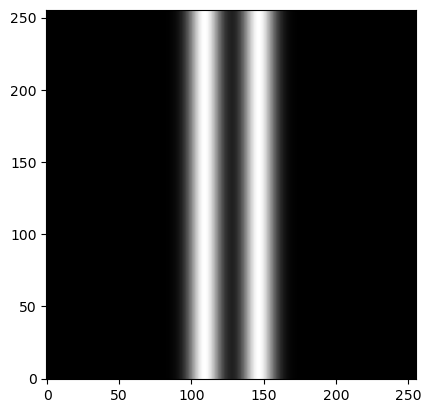

In [6]:
alpha = 0
size = 256
pixel_size = 1.068
physical_membrane_dist = 40
membrane_dist = physical_membrane_dist / pixel_size
std1 = 8
std2 = 8

line_membrane = generate_simulated_membrane(size, size/2, size/2, alpha*np.pi/180, std1, std2, membrane_dist, 0)
plt.imshow(line_membrane, cmap='gray', origin='lower')

fig = plt.figure()
ax = Axes3D(fig)
fig.add_axes(ax)
x = range(size)
y = range(size)
X, Y = np.meshgrid(x, y)
Z = line_membrane
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
plt.show()

### Add gaussian noise

In [ ]:
SNR = 0.03

line_membrane_noise = add_gaussian_noise(line_membrane, SNR)
# plot 2D figure
plt.imshow(line_membrane_noise, cmap='gray', origin='lower')

# plot 3D figure
fig2 = plt.figure()
ax2 = Axes3D(fig2)
fig2.add_axes(ax2)
x = range(size)
y = range(size)
X, Y = np.meshgrid(x, y)
Z2 = line_membrane_noise
ax2.plot_surface(X, Y, Z2, rstride=1, cstride=1, cmap='rainbow')
plt.show()

### Subtract membrane using L1-norm minimization

In [ ]:
scaling_factor_start = 0.1
scaling_factor_end = 1.2
scaling_factor_step = 0.01
rawimage = line_membrane_noise
averaged_raw_image = line_membrane

scaling_factor_lst, l1_lst, mem_subtracted = l1_norm_minimization(rawimage, averaged_raw_image, scaling_factor_start, scaling_factor_end, scaling_factor_step)

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(scaling_factor_lst, l1_lst)
ax[0].set_xlabel('scaling factor')
ax[0].set_ylabel('L1 norm')
ax[1].imshow(mem_subtracted, cmap='gray', origin='lower')

fig3 = plt.figure()
ax3 = Axes3D(fig3)
fig3.add_axes(ax3)
x = range(size)
y = range(size)
X, Y = np.meshgrid(x, y)
Z3 = mem_subtracted
ax3.plot_surface(X, Y, Z3, rstride=1, cstride=1, cmap='rainbow')
plt.show()

print('Subtracted membrane mean: ', np.mean(mem_subtracted))
print('Subtracted membrane std: ', np.std(mem_subtracted))

我们再增加一个系数$\lambda$。您可以尝试不同的$\lambda$值：

We can even add a coefficient $\lambda$. You can try different $\lambda$ values:

In [ ]:
l = 0.55

scaling_factor_start = 0.1
scaling_factor_end = 1.2
scaling_factor_step = 0.01
rawimage = line_membrane_noise * l
averaged_raw_image = line_membrane

scaling_factor_lst, l1_lst, mem_subtracted = l1_norm_minimization(rawimage, averaged_raw_image, scaling_factor_start, scaling_factor_end, scaling_factor_step)

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(scaling_factor_lst, l1_lst)
ax[0].set_xlabel('scaling factor')
ax[0].set_ylabel('L1 norm')
ax[1].imshow(mem_subtracted, cmap='gray', origin='lower')

fig3 = plt.figure()
ax3 = Axes3D(fig3)
fig3.add_axes(ax3)
x = range(size)
y = range(size)
X, Y = np.meshgrid(x, y)
Z3 = mem_subtracted
ax3.plot_surface(X, Y, Z3, rstride=1, cstride=1, cmap='rainbow')
plt.show()

print('Subtracted membrane mean: ', np.mean(mem_subtracted))
print('Subtracted membrane std: ', np.std(mem_subtracted))

## Subtraction of arc-like membrane

### Generate a simulated arc membrane

In [ ]:
beta = 0
size = 256
pixel_size = 1.068
physical_membrane_dist = 40
membrane_dist = physical_membrane_dist / pixel_size
std1 = 8
std2 = 8

arc_membrane = generate_simulated_membrane(size, size/2, size/2, beta/180*np.pi, std1, std2, membrane_dist, 0.005)
plt.imshow(arc_membrane, cmap='gray', origin='lower')

# plot 3D figure
fig4 = plt.figure()
ax4 = Axes3D(fig4)
fig4.add_axes(ax4)
x4 = range(size)
y4 = range(size)
X4, Y4 = np.meshgrid(x4, y4)
Z4 = arc_membrane
ax4.plot_surface(X4, Y4, Z4, rstride=1, cstride=1, cmap='rainbow')
plt.show()

### Add gaussian noise

In [ ]:
mean = 0
# define Signal-to-noise ratio
SNR = 0.1
# 求图像方差
variance = np.var(arc_membrane)
noise_img_variance = variance / SNR
# 求噪声标准差
std = np.sqrt(noise_img_variance)
print('noise standard deviation: ', std)
noise = np.random.normal(mean, std, (size, size))
arc_membrane_noise = arc_membrane + noise

# plot 2D figure
plt.imshow(arc_membrane_noise, cmap='gray', origin='lower')

# plot 3D figure
fig5 = plt.figure()
ax5 = Axes3D(fig5)
fig5.add_axes(ax5)
x5 = range(size)
y5 = range(size)
X5, Y5 = np.meshgrid(x5, y5)
Z5 = arc_membrane_noise
ax5.plot_surface(X5, Y5, Z5, rstride=1, cstride=1, cmap='rainbow')
plt.show()

### Subtract membrane using L1-norm minimization

In [ ]:
l2 = 0.55

scaling_factor_start = 0.1
scaling_factor_end = 1.2
scaling_factor_step = 0.01
rawimage = arc_membrane_noise * l2
averaged_raw_image = arc_membrane

scaling_factor_lst, l1_lst, mem_subtracted = l1_norm_minimization(rawimage, averaged_raw_image, scaling_factor_start, scaling_factor_end, scaling_factor_step)

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(scaling_factor_lst, l1_lst)
ax[0].set_xlabel('scaling factor')
ax[0].set_ylabel('L1 norm')
ax[1].imshow(mem_subtracted, cmap='gray', origin='lower')

fig3 = plt.figure()
ax3 = Axes3D(fig3)
fig3.add_axes(ax3)
x = range(size)
y = range(size)
X, Y = np.meshgrid(x, y)
Z3 = mem_subtracted
ax3.plot_surface(X, Y, Z3, rstride=1, cstride=1, cmap='rainbow')
plt.show()

print('Subtracted membrane mean: ', np.mean(mem_subtracted))
print('Subtracted membrane std: ', np.std(mem_subtracted))

可以看出，使用L1-norm minimization成功判断了最佳的scaling factor，并且去膜效果很好。

It can be seen that the L1-norm minimization successfully determined the best scaling factor and the membrane subtraction effect is very good.